# Feature Selection Techniques with Python

In [705]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
import seaborn as sb
from pca import pca
from sklearn.base import clone
import shap
from sklearn.metrics import mean_squared_error

In [706]:
%run featimp

Note: To avoid redundancy, I move some of codes to [featimp.py](filehttps://github.com/zren15/Feature-Importance/blob/304e9c2bb45654d7d7783737d6605d30a5dde51a/featimp.py)

## Understanding feature importance 

As we always want our model be simple and explainable, we need to select the appropriate features for our model.
Sometimes, we have many non-informative features. For Example, Name or ID variables. If we implement these variables into model, the quality of the model will be poor. Also, a large number of features make a model bulky, time-taking, and harder to implement in production.

Feature importance helps us to measure the importance of each feature in the model and assigns a score to each feature (the higher, the better). Therefore, we can "rank" those features from most important to least important in the prediction process. After we implement different feature importance strategies, we can select top K important features to do the prediction which can better explain the repsonse feature.

In this notebook, I will explore 5 feature selection methods that commonly used in machine learning with Python examples.
- Spearman's Rank Correlation
- Principle component analysis (PCA)
- SHAP Importance
- Drop Column Importance
- Permutation Importance

## Importing the data -- Boston Housing Dataset

### Variable Info

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - percentage lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.

In [707]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["PRICE"] = data.target
X = df.drop(columns=["PRICE"])   # Remove Target Variable to Get Feature Matrix
y = df["PRICE"]                  # Target Variable
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [708]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=22)
train_df.shape, val_df.shape
x_train = train_df.drop('PRICE',axis=1)
y_train = train_df['PRICE']
x_test = test_df.drop('PRICE',axis=1)
y_test = test_df['PRICE']

## Spearman's Rank Correlation

The Spearman correlation coefficient is a measure of rank correlation which measures the strength and direction of the association between 2 ranked variables. The Spearman Coefficient,⍴, can take a value between +1 to -1 where ⍴ value closer to 0 means a weaker association between 2 ranks.

We must rank the data first before processing the Spearman correlation coefficient. It is important to observe if increasing one variable, the other variable follows a monotonic relation. At every level, we need to compare the values of the two variables.

Calculation Equation：

![Alt equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/ee94267b983c2f16be1d3c61556e264762d5cba9 "equation")

### Pros and Cons

- Pros:
- ignore non-monotonic relationship forms, don't assume normal distribution


- Cons:
- low time complexity, model simplicity, and the ability to be calculated on ordinal/nominal variables

As Spearman's Rank Correlation only work well on independent variable，we first check the correlation matrix to see if it's reasonable to use it.

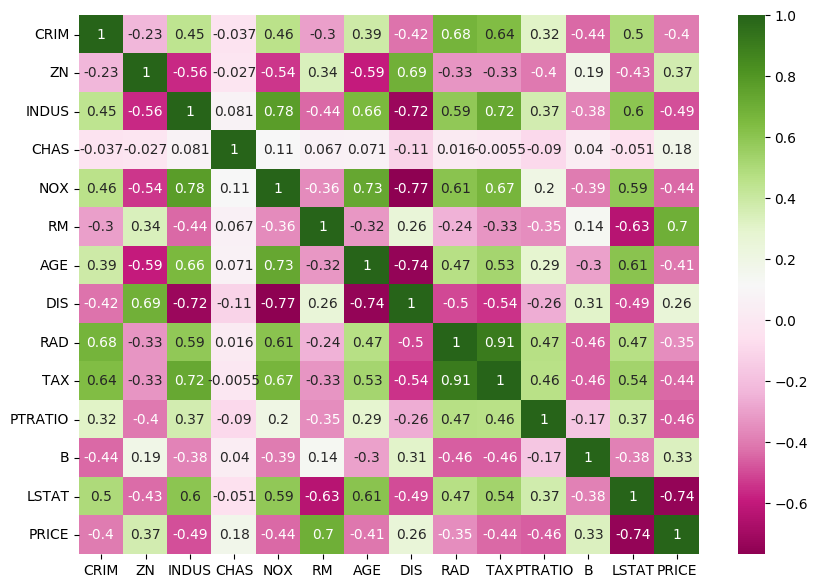

In [685]:
f, ax = plt.subplots(figsize=(10, 7))
dataplot = sb.heatmap(train_df.corr(), cmap="PiYG", annot=True)
plt.show() 

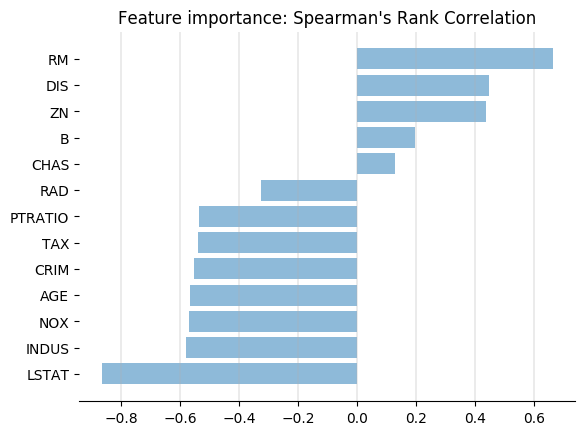

In [693]:
sort_importances = spearman_rank(train_df,y,X)

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = list(sort_importances.keys())
performance = list(sort_importances.values())
ax.barh(y_pos, performance,align='center',alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(axis='x',linewidth=0.35)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("Feature importance: Spearman's Rank Correlation")
plt.show()

* A ⍴ value of close to -1 means a negative association between ranks.
* A ⍴ value of close to +1 means a positive association between ranks.

A general notion is, the average number of rooms per dwelling (RM) increase with the house price, which means there should be a positive association between the two variables which is proved by the rs value which is over 0.6

## Principle Component Analysis (PCA)

Principle Component Analysis (PCA) is an ordination technique used primarily to display patterns in multivariate data. It aims to display the relative positions of data points in fewer dimensions while retaining as much information as possible, and explore relationships between dependent variables. 

This transformation is defined in such a way that the first principal component has the largest possible variance, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.  

Organizing information in principal components the following way, will allow us to reduce dimensionality without losing much information, and this by discarding the components with low information and considering the remaining components as your new variables.

### Pros and Cons

- Pros:
- What measures the amount of information is variance only, removes correlated features
- Orthogonality among the principal components eliminates interactions between variables of the original data.
- Easy to implement


- Cons:
- Independent variables become less interpretable
- The principal components obtained are not optimal when the samples are not normally distributed, so components with small variance in special cases may also contain important information.

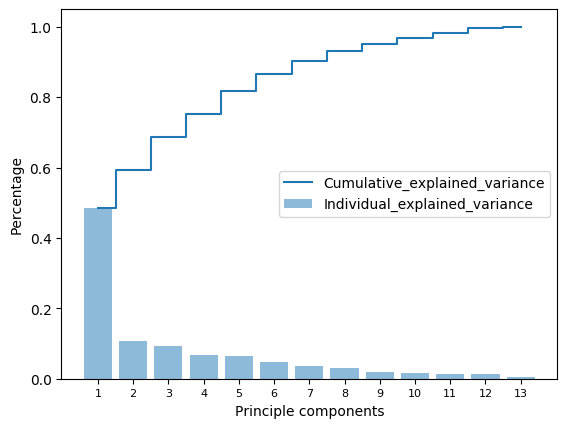

In [404]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train) 
x_test_std = sc.fit_transform(x_test)
cov_matrix = np.cov(x_train_std.T)
eigen_val, eigen_vec = np.linalg.eig(cov_matrix)
tot = sum(eigen_val) # sum of eigenvalue

# calculate the explained variance by descending order
var_exp = [(i / tot) for i in sorted(eigen_val, reverse=True)] 

# cumulative explained variance
cum_var_exp = np.cumsum(var_exp) 
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='Individual_explained_variance') 
plt.step(range(1, 14), cum_var_exp, where='mid', label='Cumulative_explained_variance') 
plt.ylabel("Percentage") 
plt.xticks(np.arange(1,14,1), np.arange(1,14,1),fontsize=8)
plt.xlabel("Principle components")
plt.legend(loc='right')
plt.show()

As there are as many principal components as there are variables in the data, principal components are constructed in such a manner that the first principal component accounts for the largest possible variance in the data set. 

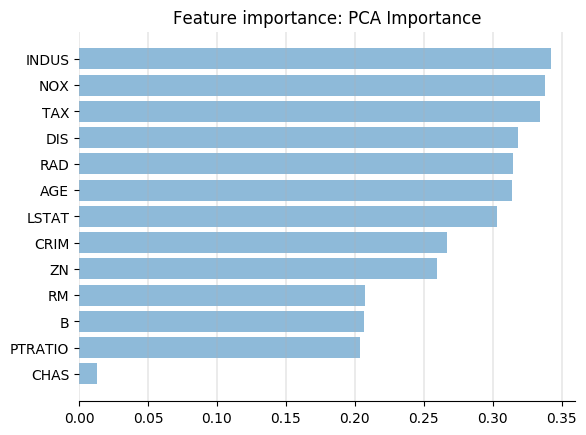

In [451]:
sort_importances = pca_importance(x_train)
    
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = list(sort_importances.keys())
performance = list(sort_importances.values())
ax.barh(y_pos, performance,align='center',alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(axis='x',linewidth=0.35)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("Feature importance: PCA Importance")
plt.show()

## Permutation Importance

This approach directly measures feature importance by observing how random re-shuffling (thus preserving the distribution of the variable) of each predictor influences model performance. It calculate relative importance score independent of model used.

Permutation importance first train the baseline model and record the score (accuracy/R²/any metric of importance).
The second step is to re-shuffle values from one feature in the selected dataset, pass the dataset to the model again to obtain predictions and calculate the metric for this modified dataset. The feature importance is the difference between the benchmark score and the one from the modified (permuted) dataset. The final step is repeat the second step till all features in the dataset.

### Pros and Cons 

- Pros:
- applicable to any model
- no need to retrain the model at each modification of the dataset


- Cons:
- gives near zero importance to highly correlated columns 

In [701]:
def calculate_permutation_importance(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    n_iter
):
    # train model
    model.fit(X, y)
    # make predictions for train data and score
    y_hat_initial = model.predict(X)
    score_r2 = r2_score(y, y_hat_initial)
    # calculate permutation importance
    importances = dict(zip(X.columns, value))

    for n in range(n_iter):
        for col in list(X.columns):
            # copy data to avoid using previously shuffled versions
            X_temp = X.copy()

            # shuffle feature_i values
            X_temp[col] = X[col].sample(X.shape[0], replace=True, random_state=random.randrange(0, 2**4)).values

            # make prediction for shuffled dataset
            y_hat = model.predict(X_temp)

            # calculate score
            score_permuted_r2 = r2_score(y, y_hat)

            # calculate delta score
            # better model <-> higher score
            # lower the delta -> more important the feature
            delta_score = score_permuted_r2 - score_r2
            # get absolute value 
            delta_score = abs(delta_score)
            # save result
            importances[col] += delta_score / n_iter

    importances_values = np.array(list(importances.values()))
    return dict(sorted(importances.items(), key = lambda kv:(kv[1], kv[0]),reverse=True))

In [702]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
model = RandomForestRegressor(n_estimators=100, n_jobs = -1)
sort_importances = calculate_permutation_importance(model,x_train,y_train,3)

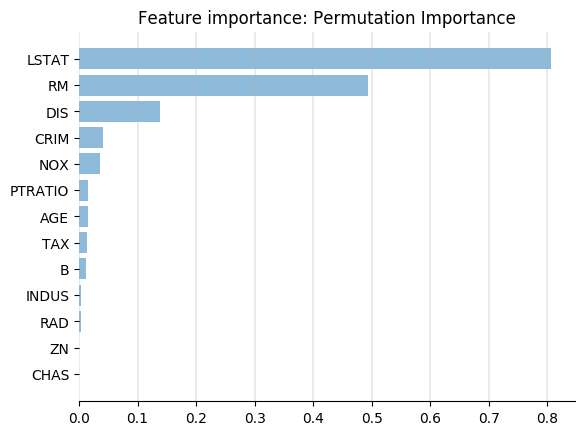

In [703]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = list(sort_importances.keys())
performance = list(sort_importances.values())
ax.barh(y_pos, performance,align='center',alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(axis='x',linewidth=0.35)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("Feature importance: Permutation Importance")
plt.show()

## Drop Column Importance

Drop Column Importance approach is quite an intuitive technique, as we investigate the importance (R-square) of a feature by comparing a model with all features versus a model with this feature dropped for training.

In the plot shown below, negative importance, in this case, means that removing a given feature from the model actually improves the performance. 

### Pros and Cons 
- Pros:
- most accurate feature importance


- Cons:
- potentially high computation cost due to retraining the model for each variant of the dataset (after dropping a single feature column)

In [491]:
model = RandomForestRegressor(n_jobs = -1)
sort_importances = dropcol_importances(model, x_train, y_train, None, None, None) 

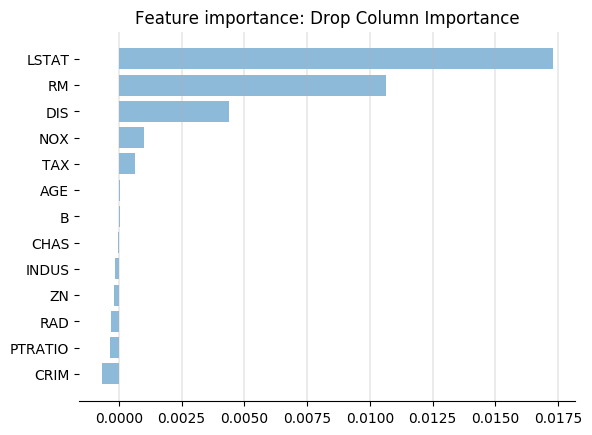

In [379]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = list(sort_importances.keys())
performance = list(sort_importances.values())
ax.barh(y_pos, performance,align='center',alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(axis='x',linewidth=0.35)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("Feature importance: Drop Column Importance")
plt.show()

## SHAP Importance

SHAP Importance represents how a feature influences the prediction of a single row relative to the other features in that row and to the average outcome in the dataset. The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction.

The SHAP explanation method computes Shapley values from coalitional game theory. The Shapley Values for one feature is the average marginal contribution of a feature value across all the possible combinations of features.

SHAP Importance is an alternative to Permutation Importance. Permutation Importance is based on the decrease in model performance, while SHAP Importance is based on magnitude of feature attributions.

### Pros and Cons 

- Pros:
- applicable to any model


- Cons:
- Hard to understand the theory

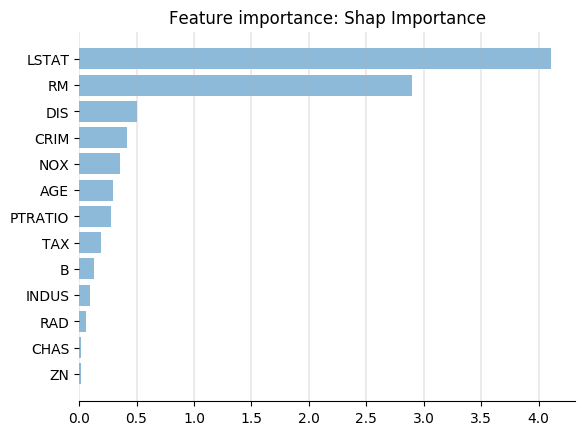

In [464]:
model= RandomForestRegressor(n_estimators=100,n_jobs = -1)
sort_importances = shap_importance(model,x_train,y_train)

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = list(sort_importances.keys())
performance = list(sort_importances.values())
ax.barh(y_pos, performance,align='center',alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(axis='x',linewidth=0.35)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title("Feature importance: Shap Importance")
plt.show()

## Comparison of different techniques

Because we as humans cannot simply look at the data and decide which features are most important, we often just rely on testing how well the recommended features work for a variety of models. For example, given a feature ranking, we can train random forest model on the top k=1..p features to see how good those features are. Here, I use Mean Square Error(MSE) as the measurement.

In [477]:
def compare_feature(model, train_df, test_df, feat_imp:dict, metric=mean_squared_error):

    MSE = []
    train = train_df.copy()
    val = test_df.copy()
    for i in range(1, 14):
        model_ = clone(model)
        model_.random_state = 3
        features = [col for col in feat_imp.keys()][:i]
        model_.fit(train.loc[:, features], train['PRICE'])
        predictions = model_.predict(val.loc[:, features])
        mse_valid = metric(val['PRICE'], predictions)
        MSE.append(mse_valid)
    return MSE

rf = RandomForestRegressor(n_estimators=100,n_jobs = -1)
spearman_featimp = spearman_rank(train_df,y,X)
pca_featimp = pca_importance(x_train)
dropcol_featimp = dropcol_importances(model, x_train, y_train, None, None, None) 
permu_featimp = calculate_permutation_importance(model,x_train,y_train,3)
shap_featimp = shap_importance(model,x_train,y_train)


mse_spearman = compare_feature(rf, train_df, test_df, feat_imp=spearman_featimp)
mse_pca = compare_feature(rf, train_df, test_df, feat_imp=pca_featimp)
mse_dropcol = compare_feature(rf, train_df, test_df, feat_imp=dropcol_featimp)
mse_permcol = compare_feature(rf, train_df, test_df, feat_imp=permu_featimp)
mse_shap = compare_feature(rf, train_df, test_df, feat_imp=shap_featimp)

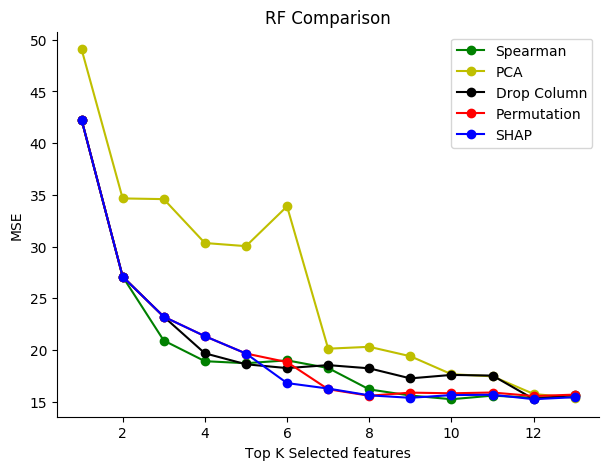

In [674]:
fig = plt.figure(figsize=(7,5))
ax = plt.axes()
plt.plot(range(1, len(mse_spearman)+1), mse_spearman, 'g', marker='o',  label='Spearman')
plt.plot(range(1, len(mse_pca)+1), mse_pca, 'y', marker='o',  label='PCA')
plt.plot(range(1, len(mse_dropcol)+1), mse_dropcol, 'k', marker='o',  label='Drop Column')
plt.plot(range(1, len(mse_permcol)+1), mse_permcol, 'r', marker='o',  label='Permutation')
plt.plot(range(1, len(mse_shap)+1), mse_shap, 'b', marker='o',  label='SHAP')

ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_ylabel('MSE', fontsize=10)
ax.set_title("RF Comparison")
ax.set_xlabel('Top K Selected features', fontsize=10)
plt.show()

## Automatic feature selection algorithm

Once you have an ordering of features from most to least important, we need a mechanism to drop off unimportant features and keep the top k, for some k we don't know beforehand. Implement an automated mechanism that selects the top k features automatically that gives the best validation error. 

Here, I develop the algorithm to drop the unimportant features based on permutation importances approach. I first get a baseline validation metric and initial feature importances. Then, for each iteration, i only drop the lowest importance feature based on the MSE and then re-compute feature importances after dropping each feature. If MSE in the next iteration gets worse, then i drop the least important feature in this iteration. I break the loop till the MSE do not decrease.

In [580]:
def permutation_importances_mse(model, x_train, y_train,  x_test, y_test):
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    baseline = mean_squared_error(y_test, prediction)
    imp = []
    for col in x_test.columns:
        save = x_test[col].copy()
        x_test[col] = np.random.permutation(x_test[col])
        m = mean_squared_error(y_test, model.predict(x_test))
        x_test[col] = save
        imp.append(baseline - m)      

    I = pd.DataFrame(data={'Feature':x_test.columns, 'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values(by = ['Importance'])
    I = I.reset_index()
    perm_list = list(I['Feature'].values)
    return perm_list

In [613]:
def auto_selection(feature_list, x_train, y_train, x_test, y_test):
    model = RandomForestRegressor(n_estimators=100,n_jobs = -1)
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    mse = mean_squared_error(y_test, prediction)
    k = len(feature_list)
    new = {}
    feature = []

    least_important_sort = feature_list[::-1] # reverse
    final = feature_list[::-1]
    for i, feat in enumerate(least_important_sort):
        print('drop feature:',feat)
        feature.append(feat)
        x_train= x_train.drop(feat, axis=1)
        x_test = x_test.drop(feat, axis=1)

        model = RandomForestRegressor(n_estimators=100,n_jobs = -1)
        model.fit(x_train, y_train)

        perm_list = permutation_importances_mse(model, x_train, y_train,  x_test, y_test)
        feat = perm_list[-1] # last important feature
        prediction = model.predict(x_test)
        mse = mean_squared_error(y_test, prediction)
        new[i] = mse
        print('MSE:',new[i])
        mse_list = list(new.values())
        min_loc = mse_list.index(min(mse_list))
        if i > 0: 
            if new[i] > new[i-1]:
                print('Stopping iterations as MSE did not decrease')
                print('Drop Feature', feature[:-1])
                break

    return new

permu_list = list(permu_featimp.keys())
tracker = auto_selection(permu_list, x_train, y_train, x_test, y_test)

drop feature: CHAS
MSE: 14.619324637254874
drop feature: ZN
MSE: 16.523215225490194
Stopping iterations as MSE did not decrease
Drop Feature ['CHAS']


## Variance for feature importances

In this section, I sample the original dataset and calculate the feature importance based on the Spearman's Rank Correlation for 100 times and get the variance of the feature importance

In [680]:
def calculate_variance_Spearman(data):
    info=[]
    for i in range(100):
        sample = data.sample(len(data),replace=True).reset_index(drop=True)
        sample_x= sample.drop(columns = 'PRICE')
        sample_y = sample['PRICE']
        info.append(spearman_rank2(sample_y,sample_x))
    return pd.DataFrame(info) 

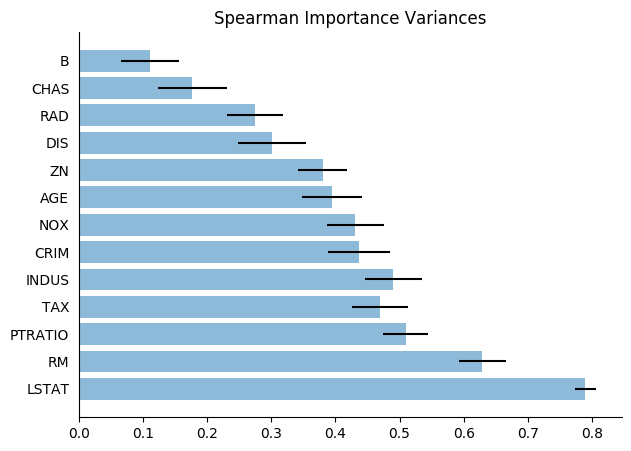

In [681]:
data = calculate_variance_Spearman(df)  

fig,ax=plt.subplots(figsize=(7,5))
ax.barh(data.columns,data.mean(),xerr=data.std(),alpha=0.5)
ax.yaxis.set_ticks_position('none')
ax.set_yticks(range(len(data.columns)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_yticklabels(data.columns,fontsize=10)
ax.set_title("Spearman Importance Variances")
plt.show()